In [19]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import models
import cv2

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

 # Loading the Data

In [2]:
images = []
masks = []
# example of mask file : ../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_13_mask.tif
# example of img file :../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11.tif
mask_dir = glob("../input/lgg-mri-segmentation/kaggle_3m/*/*_mask.tif")
for mask in mask_dir:
    masks.append(mask)
for img in masks:
    images.append(img.replace("_mask",""))
print(masks[:5])
print(images[:5])

['../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8_mask.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_34_mask.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33_mask.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_43_mask.tif']
['../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_34.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_43.tif']


# Storing The Data

In [3]:
data = pd.DataFrame({"Images": images,"Masks" : masks})
data.head()

,Images,Masks
0,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...
1,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...
2,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...
3,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...
4,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...


# Visualizing Data Using PIL

Min pixel value: 0 | Max pixel value: 237
Brain Image Dimensions: (256, 256, 3)  Mask Dimensions: (256, 256, 3)


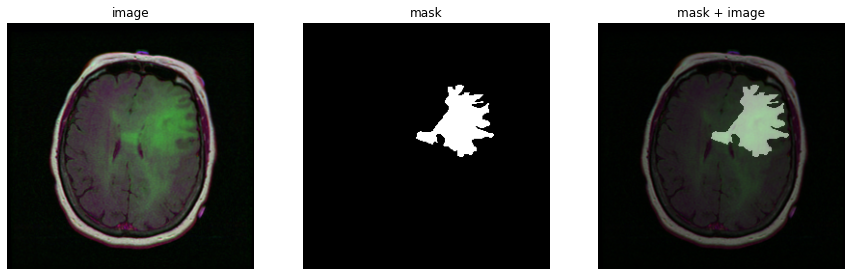

In [4]:
#TO DO : create loop that visualizes multiple rows of these 3 images (brain/mask/brain+mask(alpha=0.5))

fig = plt.figure(figsize=(15,15))
i = 2

plt.subplot(1,3,1)
plt.title('image')
plt.axis('off')
img=cv2.imread(images[i])
plt.imshow(img)

plt.subplot(1,3,2)
plt.title('mask')
plt.axis('off')
mask=cv2.imread(masks[i])
plt.imshow(mask)

plt.subplot(1,3,3)
plt.axis('off')
plt.title('mask + image')
plt.imshow(img)
plt.imshow(mask, alpha = 0.5)

print("Min pixel value:",img.min(), "| Max pixel value:",img.max())
print("Brain Image Dimensions:", img.shape, " Mask Dimensions:", mask.shape)
#256x256 3 channels (RGB)

# Split Data
Using a 72:18:10 train:val:test split

In [5]:
#there are 110 cases, we will use a split of 10% test data/18% val/72% train
train_data, test_data = train_test_split(data,test_size=0.1)
train_data, val_data = train_test_split(train_data,test_size=0.2)

#create array of training images & masks
images_read = []
masks_read = []

for i in range(0,len(images)):
    images_read.append(cv2.imread(images[i]))
    masks_read.append(cv2.imread(masks[i]))
    
#create array of validation images & masks  
val_read =[]
mask_val_read = []    
for i in range(0,len(val_data)):
    val_read.append(cv2.imread(images[i]))
    mask_val_read.append(cv2.imread(images[i]))

# Augment Data

In [6]:
#Instantiate datagenerator framework
datagen_args = ImageDataGenerator(
    samplewise_std_normalization=False,
    rotation_range=90,
    #width_shift_range=20,
    #height_shift_range=20, #test whether translation affects performance
    brightness_range=None,
    zoom_range=[0.8,1.2],
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255,
    preprocessing_function=None)

#instantiate image & mask for training and validation
image_datagen, mask_datagen, mask_val_datagen, val_datagen = datagen_args,datagen_args,datagen_args,datagen_args

In [7]:
#fitting datagens and creating datagenerator
seed = 42
image_datagen.fit(images_read, seed=seed)
mask_datagen.fit(masks_read, seed=seed)
mask_val_datagen.fit(mask_val_read, seed=seed)
val_datagen.fit(val_read, seed=seed)

In [8]:
#creating image_generators using flow_from_dataframe
image_generator = image_datagen.flow_from_dataframe(train_data,target_size=(256,256),color_mode='rgb', x_col="Images",seed=seed, class_mode=None)                                
mask_generator = mask_datagen.flow_from_dataframe(train_data,target_size=(256,256),color_mode='grayscale', x_col='Masks',seed=seed, class_mode=None)
val_generator = val_datagen.flow_from_dataframe(val_data,target_size=(256,256),color_mode='rgb', x_col="Images",seed=seed, class_mode=None)
mask_val_generator = mask_val_datagen.flow_from_dataframe(val_data,target_size=(256,256),color_mode='grayscale', x_col="Masks",seed=seed, class_mode=None)

train_zip=zip(image_generator,mask_generator)
val_zip=zip(val_generator,mask_val_generator)

Found 2828 validated image filenames.
Found 2828 validated image filenames.
Found 708 validated image filenames.
Found 708 validated image filenames.


# Building UNet Model

In [9]:
def uNet(input_shape=(256,256,3)):
    input_layer = keras.layers.Input(input_shape)
    
    conv1 = layers.Conv2D(64, (3,3), padding='same', activation='elu')(input_layer)
    conv1 = layers.Conv2D(64, (3,3), padding='same', activation='elu')(conv1)    
    batch_norm1 = layers.BatchNormalization(axis=3)(conv1)
    #layers.BatchNormalization lacks a 'Activations' arg hence following line
    batch_norm1 = layers.Activation('relu')(batch_norm1)
    pool1 = layers.MaxPool2D(pool_size=(2,2))(batch_norm1)
    
    conv2 = layers.Conv2D(128, (3,3), padding='same', activation='elu')(pool1)
    #conv2 = layers.Conv2D(128, (3,3), padding='same', activation='elu')(conv2)
    batch_norm2 = layers.BatchNormalization(axis=3)(conv2)
    batch_norm2 = layers.Activation('relu')(batch_norm2)
    pool2 = layers.MaxPool2D(pool_size=(2,2))(batch_norm2)
    
    conv3 = layers.Conv2D(256, (3,3), padding='same', activation='elu')(pool2)
    #conv3 = layers.Conv2D(256, (3,3), padding='same', activation='elu')(conv3)
    batch_norm3 = layers.BatchNormalization(axis=3)(conv3)
    batch_norm3 = layers.Activation('relu')(batch_norm3)
    pool3 = layers.MaxPool2D(pool_size=(2,2))(batch_norm3)
    
    conv4 = layers.Conv2D(512, (3,3), padding='same', activation='elu')(pool3)
    #conv4 = layers.Conv2D(512, (3,3), padding='same', activation='elu')(conv4)
    batch_norm4 = layers.BatchNormalization(axis=3)(conv4)
    batch_norm4 = layers.Activation('relu')(batch_norm4)
    pool4 = layers.MaxPool2D(pool_size=(2,2))(batch_norm4)
    
    conv5 = layers.Conv2D(1024, (3,3), padding='same', activation='elu')(pool4)
    #conv5 = layers.Conv2D(1024, (3,3), padding='same', activation='elu')(conv5)
    batch_norm5 = layers.BatchNormalization(axis=3)(conv5)
    batch_norm5 = layers.Activation('relu')(batch_norm5)
    pool5 = layers.MaxPool2D(pool_size=(2,2))(batch_norm5)
    
    skip6 = layers.concatenate([layers.Conv2DTranspose(512, (2,2), strides=(2,2), padding='same', activation='elu')(batch_norm5),conv4],axis=3)
    #conv6 = layers.Conv2D(512, (3,3), padding='same', activation='elu')(skip6)
    batch_norm6 = layers.BatchNormalization(axis=3)(skip6)
    batch_norm6 = layers.Activation('relu')(batch_norm6)
    #pool6 = layers.MaxPool2D(pool_size=(2,2))(batch_norm6)
    
    skip7 = layers.concatenate([layers.Conv2DTranspose(256, (2,2), strides=(2,2), padding='same', activation='elu')(batch_norm6),conv3],axis=3)
    #conv7 = layers.Conv2D(256, (3,3), padding='same', activation='elu')(skip7)
    batch_norm7 = layers.BatchNormalization(axis=3)(skip7)
    batch_norm7 = layers.Activation('relu')(batch_norm7)
    #pool7 = layers.MaxPool2D(pool_size=(2,2))(batch_norm7)
    
    skip8 = layers.concatenate([layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same', activation='elu')(batch_norm7),conv2],axis=3)
    #conv8 = layers.Conv2D(128, (3,3), padding='same', activation='elu')(skip8)
    batch_norm8 = layers.BatchNormalization(axis=3)(skip8)
    batch_norm8 = layers.Activation('relu')(batch_norm8)
    #pool8 = layers.MaxPool2D(pool_size=(2,2))(batch_norm8)
    
    skip9 = layers.concatenate([layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same', activation='elu')(batch_norm8),conv1],axis=3)
    #conv9 = layers.Conv2D(64, (3,3), padding='same', activation='elu')(skip9)
    batch_norm9 = layers.BatchNormalization(axis=3)(skip9)
    batch_norm9 = layers.Activation('relu')(batch_norm9)
    #pool9 = layers.MaxPool2D(pool_size=(2,2))(batch_norm9)
    
    fc10 = layers.Conv2D(1,(1,1), activation='sigmoid')(batch_norm9)
    return models.Model(inputs=input_layer, outputs=[fc10])

In [10]:
#layers.Concatenate => error 'too many axis values'; layers.concatenate => work
model = uNet(input_shape=(256,256,3))

2022-08-22 14:26:14.460384: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-22 14:26:14.593097: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-22 14:26:14.593983: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-22 14:26:14.595273: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

# Measurement Functions 

In [11]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
#(Accuracy/Sensitivity/Dice Coefficient Factor (DCF))
#Dice Coefficient

def DCF(target,pred,smooth=1):
    target=K.flatten(target)
    pred=K.flatten(pred)
    intersection = K.sum(target*pred)
    union = K.sum(target)+K.sum(pred)
    dice = ((2.0*intersection+smooth))/(union+smooth)
    return dice
def DCF_loss(target,pred):
    return 1-DCF(target,pred)

def BCE_DCF(target,pred):
    bce = tf.keras.metrics.binary_crossentropy(target,pred,from_logits=True)
    return bce+DCF(target,pred,smooth=1)
    
earlystopping = EarlyStopping(monitor='DCF_loss', mode='min', verbose=1, patience=10)
checkpointer = ModelCheckpoint(filepath="seg_model.h5", 
                               verbose=1, 
                               save_best_only=True)

In [12]:
model.compile(optimizer = 'adam', loss=BCE_DCF, metrics=['accuracy',DCF])

# Train the Model

In [13]:
#overfitting - val_loss increasing while train_loss decrease : try playing with 'smooth' & loss fn' (implement Crossentropy?)
history = model.fit(
            train_zip,
            validation_data=val_zip,
            epochs=5,
            validation_steps=len(val_data)/32,
            steps_per_epoch=len(train_data)/32,
            callbacks=[earlystopping,checkpointer])

2022-08-22 14:26:18.507534: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4994: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'
2022-08-22 14:26:21.057571: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


88/88 [==============================] - 98s 998ms/step - loss: 0.1552 - accuracy: 0.9669 - DCF: 0.0137 - val_loss: 0.2959 - val_accuracy: 0.9885 - val_DCF: 0.0147

Epoch 00001: val_loss improved from inf to 0.29586, saving model to seg_model.h5
Epoch 2/5
88/88 [==============================] - 86s 979ms/step - loss: 0.0737 - accuracy: 0.9887 - DCF: 0.0108 - val_loss: 0.1225 - val_accuracy: 0.9888 - val_DCF: 0.0124

Epoch 00002: val_loss improved from 0.29586 to 0.12254, saving model to seg_model.h5
Epoch 3/5
88/88 [==============================] - 87s 995ms/step - loss: 0.0693 - accuracy: 0.9886 - DCF: 0.0104 - val_loss: 0.0831 - val_accuracy: 0.9880 - val_DCF: 0.0147

Epoch 00003: val_loss improved from 0.12254 to 0.08311, saving model to seg_model.h5
Epoch 4/5
88/88 [==============================] - 87s 989ms/step - loss: 0.0678 - accuracy: 0.9887 - DCF: 0.0105 - val_loss: 0.0692 - val_accuracy: 0.9890 - val_DCF: 0.0129

Epoch 00004: val_loss improved from 0.08311 to 0.06924, sav

In [14]:
eval_results = model.evaluate(val_zip, steps=len(val_data)/32, verbose=1)

22/22 [==============================] - 16s 734ms/step - loss: 0.0652 - accuracy: 0.9893 - DCF: 0.0114


In [15]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'DCF', 'val_loss', 'val_accuracy', 'val_DCF'])

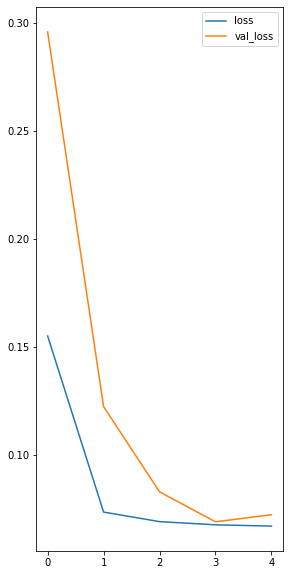

In [16]:
plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'])